Bird Species Classification Notebook

This notebook guides you through building and training a lightweight MobileNetV2-inspired model on a bird species dataset. We will:

1. Display sample images and annotate them
2. Prepare and split the dataset into train/validation/test sets
3. Implement a custom PyTorch Dataset and DataLoader
4. Define a compact MobileNetV2 variant for classification
5. Train and validate the model
6. Evaluate performance on the test set

---

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
import os, glob
from os.path import join
import random
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

## 1. Displaying a Sample Image

We define a helper to load an image from disk (in BGR format), convert it to RGB, and display it without axes. This helps verify data loading and preprocessing.

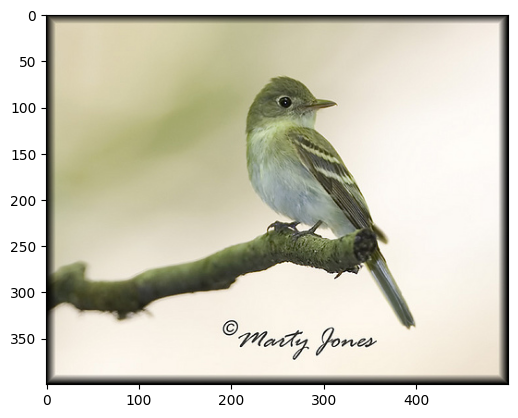

In [ ]:
def display_image(img_path: Path, dims: tuple[int, int] = (6, 6)) -> None:
    """
    Read an image (BGR), convert to RGB, and show without axes.
    """
    bgr = cv.imread(str(img_path))
    rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)
    plt.figure(figsize=dims)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

# sample usage
sample_path = Path("/kaggle/input/bird-species-classification-220-categories/Train") / \
              "Acadian_Flycatcher" / "Acadian_Flycatcher_0003_29094.jpg"
# display_image(sample_path)

## 1. Displaying a Sample Image

We define a helper to load an image from disk (in BGR format), convert it to RGB, and display it without axes. This helps verify data loading and preprocessing.

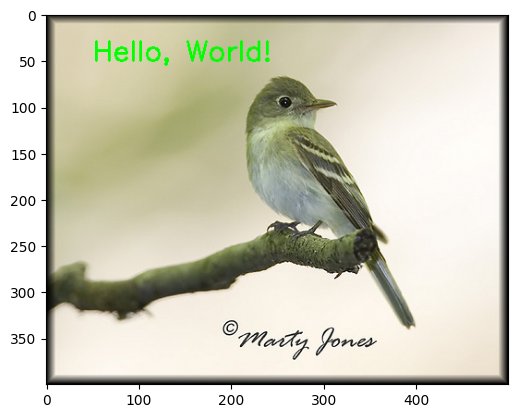

In [ ]:
# Add text overlay onto an image and display
font_face = cv.FONT_HERSHEY_SIMPLEX
scale = 1
thickness = 2
text_msg = 'Hello, World!'
pos = (50, 50)
color_bgr = (0, 255, 0)

img_sample = cv.imread(str(sample_path))
cv.putText(img_sample, text_msg, pos, font_face, scale, color_bgr, thickness)
plt.imshow(cv.cvtColor(img_sample, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 3. Preparing Dataset Paths and Labels

We set data directories, collect all label names, and create mappings from label names to indices. This establishes the ground truth for each image.

In [4]:
import os
import glob
from os.path import join

In [ ]:
# Define data directories
data_root = "/kaggle/input/bird-species-classification-220-categories"
train_root = join(data_root, "Train")
test_root = join(data_root, "Test")

# gather labels
dirs = os.listdir(train_root) + os.listdir(test_root)
labels = sorted(set(dirs))

# create mappings
lbl_to_idx = {lbl: i for i, lbl in enumerate(labels)}
idx_to_lbl = {i: lbl for lbl, i in lbl_to_idx.items()}

print(f"Total classes: {len(labels)}")

## 4. Splitting into Train, Validation, and Test

We gather all image file paths, shuffle them, and split the training set into train and validation subsets (80/20 split). Test set remains separate.

In [ ]:
# Define data directories
data_root = "/kaggle/input/bird-species-classification-220-categories"
train_root = join(data_root, "Train")
test_root = join(data_root, "Test")

# gather labels
dirs = os.listdir(train_root) + os.listdir(test_root)
labels = sorted(set(dirs))

# create mappings
lbl_to_idx = {lbl: i for i, lbl in enumerate(labels)}
idx_to_lbl = {i: lbl for lbl, i in lbl_to_idx.items()}

print(f"Total classes: {len(labels)}")
labels.sort()
print(labels)

['Acadian_Flycatcher', 'American_Crow', 'American_Goldfinch', 'American_Pipit', 'American_Redstart', 'American_Three_toed_Woodpecker', 'Anna_Hummingbird', 'Artic_Tern', 'Baird_Sparrow', 'Baltimore_Oriole', 'Bank_Swallow', 'Barn_Swallow', 'Bay_breasted_Warbler', 'Belted_Kingfisher', 'Bewick_Wren', 'Black_Tern', 'Black_and_white_Warbler', 'Black_billed_Cuckoo', 'Black_capped_Vireo', 'Black_footed_Albatross', 'Black_throated_Blue_Warbler', 'Black_throated_Sparrow', 'Blue_Grosbeak', 'Blue_Jay', 'Blue_headed_Vireo', 'Blue_winged_Warbler', 'Boat_tailed_Grackle', 'Bobolink', 'Bohemian_Waxwing', 'Brandt_Cormorant', 'Brewer_Blackbird', 'Brewer_Sparrow', 'Bronzed_Cowbird', 'Brown_Creeper', 'Brown_Pelican', 'Brown_Thrasher', 'Cactus_Wren', 'California_Gull', 'Canada_Warbler', 'Cape_Glossy_Starling', 'Cape_May_Warbler', 'Cardinal', 'Carolina_Wren', 'Caspian_Tern', 'Cedar_Waxwing', 'Cerulean_Warbler', 'Chestnut_sided_Warbler', 'Chipping_Sparrow', 'Chuck_will_Widow', 'Clark_Nutcracker', 'Clay_colore

In [ ]:
label2index = { label:idx for idx, label in enumerate(label_names)}
index2label = list(label2index.keys())
print(label2index['Acadian_Flycatcher'], index2label[0])

0 Acadian_Flycatcher


In [ ]:
# collect all image file paths
all_train_paths = glob.glob(join(train_root, "*/*.jpg"))
test_paths = glob.glob(join(test_root, "*/*.jpg"))
print({len(all_train_paths)},{len(test_paths)})

(9414, 2374)

In [ ]:
# split train into train and validation
random.shuffle(all_train_paths)
val_fraction = 0.2
val_count = int(len(all_train_paths) * val_fraction)
valid_paths = all_train_paths[-val_count:]
train_paths = all_train_paths[:-val_count]
print({len(train_paths)},{len(valid_paths)},{len(test_paths)})

(7532, 1882, 2374)

## 5. Generating Numeric Labels

Using `tqdm` for progress, we map each image path to its numeric label by extracting the parent folder name.

In [ ]:
# generate numeric labels using tqdm for progress
train_labels, valid_labels, test_labels = [], [], []
for paths, container in [(train_paths, train_labels), (valid_paths, valid_labels), (test_paths, test_labels)]:
    for p in tqdm(paths, desc='Labeling'):
        cls = Path(p).parent.name
        container.append(lbl_to_idx[cls])

## 6. Defining a Custom PyTorch Dataset

We implement `BirdsDataset` inheriting from `torch.utils.data.Dataset`, handling image loading, resizing to 224×224, normalization, and tensor conversion.

In [ ]:
class BirdsData(Dataset):
    """Custom Dataset for bird images."""
    def __init__(self, paths_list, labels_list):
        self.paths = paths_list
        self.labels = labels_list

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv.imread(self.paths[idx])
        img = cv.resize(img, (224, 224)) / 255.0
        img_t = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        lbl_t = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"inputs": img_t, "targets": lbl_t}

# test dataset
train_ds = BirdsData(train_paths, train_labels)
print(train_ds[0]['inputs'].shape, train_ds[0]['targets'])

## 7. DataLoaders

Wrap datasets into `DataLoader`s for batch processing. We use batch size 64 for training and validation, and batch size 1 for testing.

In [ ]:
# create loaders
BATCH = 64
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(BirdsData(valid_paths, valid_labels), batch_size=BATCH)
test_loader = DataLoader(BirdsData(test_paths, test_labels), batch_size=1)

# inspect a batch
batch = next(iter(train_loader))
print(batch['inputs'].shape, batch['targets'].shape)

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

## 8. Model Definition: MobileNetV2-inspired

We define a light version of MobileNetV2 with:
- `make_divisible` for channel rounding
- Convolutional blocks with BatchNorm and ReLU6
- Inverted residual blocks with expansion and depthwise convolutions

In [ ]:
def make_divisible(v, divisor, min_val=None):
    """Ensure channel counts are divisible by divisor."""
    if min_val is None:
        min_val = divisor
    new_v = max(min_val, int(v + divisor/2)//divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class Conv3x3Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU6(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class InvertedBlock(nn.Module):
    def __init__(self, in_c, out_c, stride, expand):
        super().__init__()
        hidden = round(in_c * expand)
        self.use_residual = (stride==1 and in_c==out_c)
        layers = []
        if expand != 1:
            layers += [nn.Conv2d(in_c, hidden, 1, bias=False), nn.BatchNorm2d(hidden), nn.ReLU6(inplace=True)]
        layers += [nn.Conv2d(hidden, hidden, 3, stride, 1, groups=hidden, bias=False),
                   nn.BatchNorm2d(hidden), nn.ReLU6(inplace=True),
                   nn.Conv2d(hidden, out_c, 1, bias=False), nn.BatchNorm2d(out_c)]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        res = self.conv(x)
        return x + res if self.use_residual else res

class MobileNetTiny(nn.Module):
    def __init__(self, num_cls=1000, mult=1.0):
        super().__init__()
        cfgs = [[1,16,1,1],[6,24,2,2],[6,32,3,2],[6,64,4,2],[6,96,3,1],[6,160,3,2],[6,320,1,1]]
        in_c = make_divisible(32 * mult, 8)
        layers = [Conv3x3Block(3, in_c, 2)]
        for t, c, n, s in cfgs:
            out_c = make_divisible(c * mult, 8)
            for i in range(n):
                layers.append(InvertedBlock(in_c, out_c, s if i==0 else 1, t))
                in_c = out_c
        last_c = make_divisible(1280 * mult, 8) if mult>1 else 1280
        layers += [nn.Conv2d(in_c, last_c, 1, bias=False), nn.BatchNorm2d(last_c), nn.ReLU6(inplace=True)]
        self.features = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(last_c, num_cls)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)

def create_mobile_model(num_classes):
    return MobileNetTiny(num_classes)

# initialize
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = create_mobile_model(len(labels)).to(device)
_ = model(torch.zeros(1,3,224,224).to(device))
model(torch.zeros(1,3,224,224))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddmmBackward0>)

## 9. Training Loop

We train for 100 epochs with Adam optimizer and CrossEntropyLoss. Training and validation accuracy/loss are logged and the best model is saved.

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 32

dataset_train = BirdsData(train_paths, train_labels)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_val = val_loader  # already defined

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
top_acc = 0.0

for epoch in range(1, NUM_EPOCHS+1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    model.train()
    with tqdm(total=len(loader_train), desc='Training') as prog:
        for imgs in loader_train:
            opt.zero_grad()
            inputs = imgs['inputs'].to(device)
            targets = imgs['targets'].to(device)
            preds = model(inputs)
            loss = loss_fn(preds, targets)
            acc = (preds.argmax(1) == targets).float().mean().item()
            loss.backward()
            opt.step()
            prog.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}")
            prog.update(1)

    # validation
    model.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for batch in loader_val:
            x = batch['inputs'].to(device)
            y = batch['targets'].to(device)
            out = model(x)
            l = loss_fn(out, y)
            a = (out.argmax(1) == y).float().mean().item()
            val_losses.append(l.item())
            val_accs.append(a)
    mean_loss = np.mean(val_losses); mean_acc = np.mean(val_accs)
    print(f"Val loss: {mean_loss:.4f}, Val acc: {mean_acc:.4f}")
    if mean_acc > top_acc:
        torch.save(model.state_dict(), 'best_model.pth')
        top_acc = mean_acc

Epoch: 1/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.9399 - Val_acc: 0.0143
Epoch: 2/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.7631 - Val_acc: 0.0218
Epoch: 3/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.6233 - Val_acc: 0.0266
Epoch: 4/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.4123 - Val_acc: 0.0478
Epoch: 5/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.4262 - Val_acc: 0.0404
Epoch: 6/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.0957 - Val_acc: 0.0675
Epoch: 7/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.3099 - Val_acc: 0.0712
Epoch: 8/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.8826 - Val_acc: 0.1015
Epoch: 9/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.7756 - Val_acc: 0.1334
Epoch: 10/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.5684 - Val_acc: 0.1647
Epoch: 11/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.5324 - Val_acc: 0.1594
Epoch: 12/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.8633 - Val_acc: 0.1472
Epoch: 13/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.5834 - Val_acc: 0.1716
Epoch: 14/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.7405 - Val_acc: 0.1716
Epoch: 15/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.5886 - Val_acc: 0.2083
Epoch: 16/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.5751 - Val_acc: 0.2264
Epoch: 17/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.9524 - Val_acc: 0.1971
Epoch: 18/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 3.8884 - Val_acc: 0.2221
Epoch: 19/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.2214 - Val_acc: 0.2051
Epoch: 20/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.2258 - Val_acc: 0.2024
Epoch: 21/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.2546 - Val_acc: 0.2072
Epoch: 22/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.4658 - Val_acc: 0.1993
Epoch: 23/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.7076 - Val_acc: 0.2163
Epoch: 24/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 4.8422 - Val_acc: 0.2216
Epoch: 25/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.2233 - Val_acc: 0.2030
Epoch: 26/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.0987 - Val_acc: 0.2216
Epoch: 27/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.4302 - Val_acc: 0.2035
Epoch: 28/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.7251 - Val_acc: 0.1971
Epoch: 29/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.3431 - Val_acc: 0.2237
Epoch: 30/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.4911 - Val_acc: 0.2088
Epoch: 31/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.9790 - Val_acc: 0.2125
Epoch: 32/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.5899 - Val_acc: 0.2131
Epoch: 33/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.8327 - Val_acc: 0.2253
Epoch: 34/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.9500 - Val_acc: 0.2274
Epoch: 35/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.0464 - Val_acc: 0.2147
Epoch: 36/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 5.8648 - Val_acc: 0.2163
Epoch: 37/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.5257 - Val_acc: 0.1955
Epoch: 38/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.3661 - Val_acc: 0.2216
Epoch: 39/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.3868 - Val_acc: 0.2194
Epoch: 40/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.2399 - Val_acc: 0.2253
Epoch: 41/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.2302 - Val_acc: 0.2343
Epoch: 42/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.4085 - Val_acc: 0.2109
Epoch: 43/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.2980 - Val_acc: 0.2279
Epoch: 44/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.3932 - Val_acc: 0.2226
Epoch: 45/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.3062 - Val_acc: 0.2258
Epoch: 46/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.3478 - Val_acc: 0.2365
Epoch: 47/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.3500 - Val_acc: 0.2248
Epoch: 48/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.4578 - Val_acc: 0.2200
Epoch: 49/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.8162 - Val_acc: 0.2184
Epoch: 50/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.5774 - Val_acc: 0.2189
Epoch: 51/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.5676 - Val_acc: 0.2311
Epoch: 52/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.4725 - Val_acc: 0.2279
Epoch: 53/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.3813 - Val_acc: 0.2375
Epoch: 54/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.7511 - Val_acc: 0.2179
Epoch: 55/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.7771 - Val_acc: 0.2322
Epoch: 56/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.8127 - Val_acc: 0.2131
Epoch: 57/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.6235 - Val_acc: 0.2242
Epoch: 58/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.7265 - Val_acc: 0.2221
Epoch: 59/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.9418 - Val_acc: 0.2253
Epoch: 60/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.7765 - Val_acc: 0.2386
Epoch: 61/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.4179 - Val_acc: 0.1987
Epoch: 62/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.6859 - Val_acc: 0.2365
Epoch: 63/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.6334 - Val_acc: 0.2365
Epoch: 64/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.6954 - Val_acc: 0.2290
Epoch: 65/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.8573 - Val_acc: 0.2194
Epoch: 66/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.8084 - Val_acc: 0.2264
Epoch: 67/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.0366 - Val_acc: 0.2237
Epoch: 68/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.8555 - Val_acc: 0.2269
Epoch: 69/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.3626 - Val_acc: 0.2120
Epoch: 70/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.8331 - Val_acc: 0.2396
Epoch: 71/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.8607 - Val_acc: 0.2333
Epoch: 72/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.1360 - Val_acc: 0.2333
Epoch: 73/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.3483 - Val_acc: 0.2194
Epoch: 74/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.0470 - Val_acc: 0.2237
Epoch: 75/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.0302 - Val_acc: 0.2391
Epoch: 76/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.7011 - Val_acc: 0.2503
Epoch: 77/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.0034 - Val_acc: 0.2210
Epoch: 78/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.2463 - Val_acc: 0.2221
Epoch: 79/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.0882 - Val_acc: 0.2343
Epoch: 80/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.3823 - Val_acc: 0.2094
Epoch: 81/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.1106 - Val_acc: 0.2327
Epoch: 82/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.4155 - Val_acc: 0.2189
Epoch: 83/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.9869 - Val_acc: 0.2349
Epoch: 84/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.3224 - Val_acc: 0.2141
Epoch: 85/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.3457 - Val_acc: 0.2285
Epoch: 86/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.2066 - Val_acc: 0.2365
Epoch: 87/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.2166 - Val_acc: 0.2285
Epoch: 88/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.2102 - Val_acc: 0.2194
Epoch: 89/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.2301 - Val_acc: 0.2338
Epoch: 90/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.2851 - Val_acc: 0.2359
Epoch: 91/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.1179 - Val_acc: 0.2269
Epoch: 92/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.3144 - Val_acc: 0.2242
Epoch: 93/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.4677 - Val_acc: 0.2216
Epoch: 94/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.4176 - Val_acc: 0.2311
Epoch: 95/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.4305 - Val_acc: 0.2194
Epoch: 96/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.2869 - Val_acc: 0.2088
Epoch: 97/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 7.2559 - Val_acc: 0.2147
Epoch: 98/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.9899 - Val_acc: 0.2274
Epoch: 99/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.7779 - Val_acc: 0.2428
Epoch: 100/100


  0%|          | 0/236 [00:00<?, ?it/s]

Validation


  0%|          | 0/1882 [00:00<?, ?it/s]

Val_loss: 6.9844 - Val_acc: 0.2439


## 10. Test Set Evaluation

Load the best saved model and compute loss and accuracy on the held-out test set.

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_losses, test_accs = [], []
with torch.no_grad():
    for batch in test_loader:
        x = batch['inputs'].to(device)
        y = batch['targets'].to(device)
        out = model(x)
        loss = loss_fn(out, y)
        acc = (out.argmax(1) == y).float().mean().item()
        test_losses.append(loss.item())
        test_accs.append(acc)
print(f"Test loss: {np.mean(test_losses):.4f}, Test acc: {np.mean(test_accs):.4f}")

  0%|          | 0/1882 [00:00<?, ?it/s]

Test_loss: 6.9844 - Test_acc: 0.2439


## 11. Next Steps

- Infer on new images and overlay predicted labels
- Visualize training curves (loss & accuracy)
- Experiment with data augmentation and learning rate schedules